In [1]:
#@title Mount Google Drive (Optional) {display-mode: "form"}

# Mount Google Drive if you want to access saved photos/videos to test in age classification below.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Library Imports {display-mode: "form"}

# Please refer to requirements.txt for a full list of all libraries and their versions used in this project.

import numpy as np
import cv2
from google.colab.patches import cv2_imshow    # cv.imshow() is known to crash Google Colab notebooks. This is the alternative suggested by Colab.
import os
from tensorflow.keras.models import load_model

In [3]:
#@title Load Age Detection Model {display-mode: "form"}

# Getting the trained CNN model from the source link.
!wget -qq "https://drive.google.com/uc?export=download&id=12MgZBpQ0N7suHnNecVMj_ae9zYqbjAhF" -O "age_detect_cnn_model.h5"

# Loading the trained CNN model for age classification, and defining a list of age-ranges as defined in the model.
model = load_model("age_detect_cnn_model.h5")
age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

In [4]:
#@title Load Face Detection Model {display-mode: "form"}

# Getting the trained CNN model from the source link.
!wget -qq "https://drive.google.com/uc?export=download&id=1Gcz4wc8iA1SHfV9REcK4i74Tf9vaETq7" -O "haarcascade_frontalface_default.xml"

# Importing the Haar Cascades classifier XML file.
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [5]:
#@title Define Necessary Functions {display-mode: "form"}

# Defining a function to shrink the detected face region by a scale for better prediction in the model.

def shrink_face_roi(x, y, w, h, scale=0.9):
    wh_multiplier = (1-scale)/2
    x_new = int(x + (w * wh_multiplier))
    y_new = int(y + (h * wh_multiplier))
    w_new = int(w * scale)
    h_new = int(h * scale)
    return (x_new, y_new, w_new, h_new)


# Defining a function to create the predicted age overlay on the image by centering the text.

def create_age_text(img, text, pct_text, x, y, w, h):

    # Defining font, scales and thickness.
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    text_scale = 1.2
    yrsold_scale = 0.7
    pct_text_scale = 0.65

    # Getting width, height and baseline of age text and "years old".
    (text_width, text_height), text_bsln = cv2.getTextSize(text, fontFace=fontFace, fontScale=text_scale, thickness=2)
    (yrsold_width, yrsold_height), yrsold_bsln = cv2.getTextSize("years old", fontFace=fontFace, fontScale=yrsold_scale, thickness=1)
    (pct_text_width, pct_text_height), pct_text_bsln = cv2.getTextSize(pct_text, fontFace=fontFace, fontScale=pct_text_scale, thickness=1)

    # Calculating center point coordinates of text background rectangle.
    x_center = x + (w/2)
    y_text_center = y + h + 20
    y_yrsold_center = y + h + 48
    y_pct_text_center = y + h + 75

    # Calculating bottom left corner coordinates of text based on text size and center point of background rectangle calculated above.
    x_text_org = int(round(x_center - (text_width / 2)))
    y_text_org = int(round(y_text_center + (text_height / 2)))
    x_yrsold_org = int(round(x_center - (yrsold_width / 2)))
    y_yrsold_org = int(round(y_yrsold_center + (yrsold_height / 2)))
    x_pct_text_org = int(round(x_center - (pct_text_width / 2)))
    y_pct_text_org = int(round(y_pct_text_center + (pct_text_height / 2)))

    face_age_background = cv2.rectangle(img, (x-1, y+h), (x+w+1, y+h+94), (0, 100, 0), cv2.FILLED)
    face_age_text = cv2.putText(img, text, org=(x_text_org, y_text_org), fontFace=fontFace, fontScale=text_scale, thickness=2, color=(255, 255, 255), lineType=cv2.LINE_AA)
    yrsold_text = cv2.putText(img, "years old", org=(x_yrsold_org, y_yrsold_org), fontFace=fontFace, fontScale=yrsold_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)
    pct_age_text = cv2.putText(img, pct_text, org=(x_pct_text_org, y_pct_text_org), fontFace=fontFace, fontScale=pct_text_scale, thickness=1, color=(255, 255, 255), lineType=cv2.LINE_AA)

    return (face_age_background, face_age_text, yrsold_text)


# Defining a function to find faces in an image and then classify each found face into age-ranges defined above.

def classify_age(img):

    # Making a copy of the image for overlay of ages and making a grayscale copy for passing to the loaded model for age classification.
    img_copy = np.copy(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecting faces in the image using the face_cascade loaded above and storing their coordinates into a list.
    faces = face_cascade.detectMultiScale(img_copy, scaleFactor=1.2, minNeighbors=6, minSize=(100, 100))
    # print(f"{len(faces)} faces found.")

    # Looping through each face found in the image.
    for i, (x, y, w, h) in enumerate(faces):

        # Drawing a rectangle around the found face.
        face_rect = cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 100, 0), thickness=2)
        
        # Predicting the age of the found face using the model loaded above.
        x2, y2, w2, h2 = shrink_face_roi(x, y, w, h)
        face_roi = img_gray[y2:y2+h2, x2:x2+w2]
        face_roi = cv2.resize(face_roi, (200, 200))
        face_roi = face_roi.reshape(-1, 200, 200, 1)
        face_age = age_ranges[np.argmax(model.predict(face_roi))]
        face_age_pct = f"({round(np.max(model.predict(face_roi))*100, 2)}%)"
        
        # Calling the above defined function to create the predicted age overlay on the image.
        face_age_background, face_age_text, yrsold_text = create_age_text(img_copy, face_age, face_age_pct, x, y, w, h)
        # print(f"Age prediction for face {i+1} : {face_age} years old")

    return img_copy


# Defining a function to return the image filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_image.jpg", OUTPUT filepath will be "my_folder1/my_folder2/my_image_WITH_AGE.jpg"

def new_img_name(org_img_path):
    img_path, img_name_ext = os.path.split(org_img_path)
    img_name, img_ext = os.path.splitext(img_name_ext)

    new_img_name_ext = img_name+"_WITH_AGE"+img_ext
    new_img_path = os.path.join(img_path, new_img_name_ext)

    return new_img_path


# Defining a function to return the video filepath with a new filename.
# If INPUT filepath is "my_folder1/my_folder2/my_video.mp4", OUTPUT filepath will be "my_folder1/my_folder2/my_video_WITH_AGE.mp4"

def new_vid_name(org_vid_path):
    vid_path, vid_name_ext = os.path.split(org_vid_path)
    vid_name, vid_ext = os.path.splitext(vid_name_ext)

    new_vid_name_ext = vid_name+"_WITH_AGE"+".mp4"
    new_vid_path = os.path.join(vid_path, new_vid_name_ext)

    return new_vid_path

# Age Detection on Image

<IPython.core.display.Javascript object>

Saved to my_photo.jpg


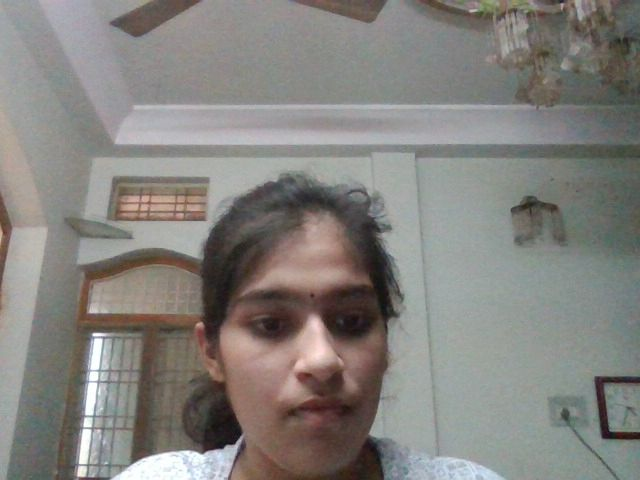

In [ ]:
#@title Capture Webcam Image {display-mode: "form"}

# Webcam image capture
# Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='my_photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


from IPython.display import Image
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
  
    # Show the image which was just taken.
    display(Image(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

In [14]:
# Provide the image filepath as a string below.


my_image = "/content/drive/My Drive/age_classification/code/mf.png"
#my_image = "my_photo.jpg"

Saved to /content/drive/My Drive/age_classification/code/mf_WITH_AGE.png


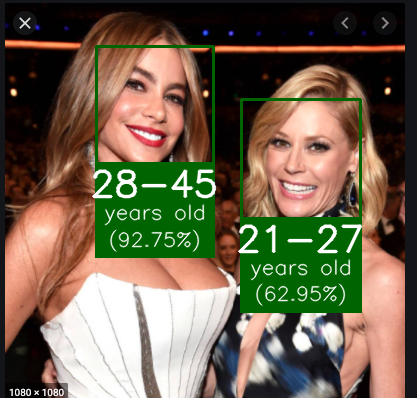

In [15]:
#@title Run Age Detection on Image {display-mode: "form"}

# Reading the image from filepath provided above and passing it through the age clasification method defined above.

img = cv2.imread(my_image)
age_img = classify_age(img)

# Saving the new generated image with a new name at the same location. 
try:
    new_my_image = new_img_name(my_image)
    cv2.imwrite(new_my_image, age_img)
    print(f"Saved to {new_my_image}")
except:
    print("Error: Could not save image!")

cv2_imshow(age_img)